In [ ]:
!pip install sparkmonitor

In [ ]:
!pip install pyspark

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import sparkmonitor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [2]:
import os
os.environ["SPARK_HOME"]="D:\spark\spark-2.4.0-bin-hadoop2.7"
os.environ["JAVA_HOME"]="D:\Program Files\java all\jdk.8.191"

In [3]:
# !jupyter nbextension install sparkmonitor --py --user --symlink 
# !jupyter nbextension enable sparkmonitor --py --user            
# !jupyter serverextension enable --py --user sparkmonitor
# !ipython profile create && echo "c.InteractiveShellApp.extensions.append('sparkmonitor.kernelextension')" >>  $(ipython profile locate default)/ipython_kernel_config.py

sc=SparkContext(appName='MovieRecomendations')
spark = SparkSession.builder.appName('MovieRecomendations').getOrCreate()

In [4]:
data = spark.read.csv('data/311_request.csv', sep=',', header=True) #311_Service_Requests_from_2010_to_Present.csv',sep=',', header=True)

In [5]:
data.printSchema()

root
 |-- Unique Key: string (nullable = true)
 |-- Created Date: string (nullable = true)
 |-- Closed Date: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Agency Name: string (nullable = true)
 |-- Complaint Type: string (nullable = true)
 |-- Descriptor: string (nullable = true)
 |-- Location Type: string (nullable = true)
 |-- Incident Zip: string (nullable = true)
 |-- Incident Address: string (nullable = true)
 |-- Street Name: string (nullable = true)
 |-- Cross Street 1: string (nullable = true)
 |-- Cross Street 2: string (nullable = true)
 |-- Intersection Street 1: string (nullable = true)
 |-- Intersection Street 2: string (nullable = true)
 |-- Address Type: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Landmark: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Due Date: string (nullable = true)
 |-- Resolution Action Updated Date: string (nullable = true)
 |-- Community

In [ ]:
#data.describe(['Open Data Channel Type']).show()

In [ ]:
#data.groupBy('Vehicle Type').count().show()

### Count()

##### Agency Name:

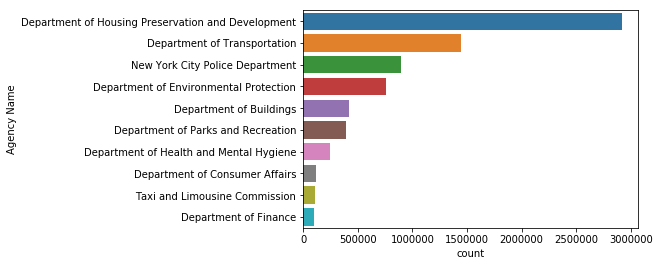

In [55]:
dataPrint = data.groupBy("Agency Name").count()
dfP = dataPrint.toPandas()
sns.barplot(y="Agency Name", x="count", data=dfP.sort_values(by='count', ascending=False).head(10));

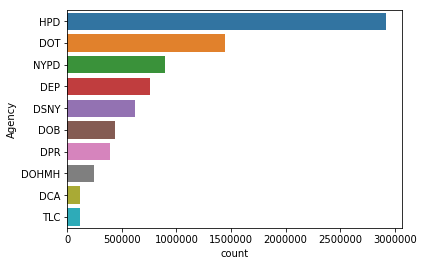

In [56]:
dataPrint = data.groupBy("Agency").count()
dfP = dataPrint.toPandas()
sns.barplot(y="Agency", x="count", data=dfP.sort_values(by='count', ascending=False).head(10));

##### Complaint Type:

In [ ]:
dataPrint = data.groupBy("Complaint Type").count()
dfP = dataPrint.toPandas()

In [ ]:
sns.barplot(y="Complaint Type", x="count", data=dfP.sort_values(by='count', ascending=False).head(20));

##### Location Type:

In [ ]:
dataPrint = data.groupBy("Location Type").count()
dfP = dataPrint.toPandas()

In [ ]:
sns.barplot(y="Location Type", x="count", data=dfP.sort_values(by='count', ascending=False).head(20));

##### Street Name:

In [ ]:
dataPrint = data.groupBy("Street Name").count()
dfP = dataPrint.toPandas()

In [ ]:
sns.barplot(y="Street Name", x="count", data=dfP.sort_values(by='count', ascending=False).head(20));

##### Status:

In [ ]:
dataPrint = data.groupBy("Status").count()
dfP = dataPrint.toPandas()
sns.barplot(y="Status", x="count", data=dfP.sort_values(by='count', ascending=False).head(5));

##### Borough:

In [ ]:
dataPrint = data.groupBy("Borough").count()
dfP = dataPrint.toPandas()
sns.barplot(y="Borough", x="count", data=dfP.sort_values(by='count', ascending=False).head(10));

### Timestamp

In [6]:
from pyspark.sql.functions import to_timestamp

In [7]:
myData = data
split_col = functions.split(myData['Borough'], ' ')

In [ ]:
toPrint = test.groupBy("CreatedDate2").count().toPandas()
toPrint["CreatedDate2"] = pd.to_datetime(toPrint["CreatedDate2"])
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
sns.lineplot(y="count", x="CreatedDate2", data=toPrint)
plt.xticks(rotation=90);

In [8]:
myData = myData.withColumn('District', split_col.getItem(0))

In [9]:
cols = [to_timestamp('Created Date', 'MM/dd/yyy').alias('CreatedDate'), to_timestamp('Closed Date', 'MM/dd/yyy').alias('ClosedDate'), 'Status', 'Agency','Complaint Type','City','District','Latitude','Longitude']
myData = myData.select(cols).filter("Status='Closed'")
myData = myData.filter(myData['CreatedDate']>'2011-01-01').filter(myData['ClosedDate']<'2013-01-01')
myData = myData.withColumn('DelayInDays', functions.unix_timestamp(myData.ClosedDate)/86400-functions.unix_timestamp(myData.CreatedDate)/86400)


In [10]:
cols = ['District', 'City', 'Agency', 'Complaint Type', 'DelayInDays','CreatedDate', 'Latitude','Longitude']
myData = myData.select(cols).filter(myData['District']!='Unspecified')

In [11]:
baseData = myData.toPandas()

In [12]:
import copy
myData_pd = copy.deepcopy(baseData)

In [13]:
myData_pd = myData_pd.where(myData_pd["Latitude"]>'')

In [14]:
myData_pd.Latitude = [float(x) for x in myData_pd.Latitude]
myData_pd = myData_pd.where(myData_pd["Latitude"]>-360)
myData_pd.Longitude = [float(x) for x in myData_pd.Longitude]
myData_pd = myData_pd.where(myData_pd["Longitude"]>-360)

In [15]:
def is_nan(x):
    return (x is np.nan or x != x)

In [16]:
myData_pd = myData_pd.where(myData_pd["District"]>'')
myData_pd = myData_pd.dropna()

In [17]:
myData_pd.where(myData_pd.District == 'BRONX').dropna()

,District,City,Agency,Complaint Type,DelayInDays,CreatedDate,Latitude,Longitude
5,BRONX,BRONX,NYPD,Blocked Driveway,0.0,2012-12-31,40.904051,-73.849290
24,BRONX,BRONX,NYPD,Blocked Driveway,0.0,2012-12-31,40.891754,-73.845123
27,BRONX,BRONX,NYPD,Illegal Parking,0.0,2012-12-31,40.833205,-73.867617
43,BRONX,BRONX,NYPD,Illegal Parking,0.0,2012-12-31,40.877119,-73.838554
49,BRONX,BRONX,NYPD,Illegal Parking,0.0,2012-12-31,40.840868,-73.921820
51,BRONX,BRONX,DSNY,Dirty Conditions,0.0,2012-12-31,40.837761,-73.831378
63,BRONX,BRONX,NYPD,Illegal Parking,0.0,2012-12-31,40.833683,-73.885749
68,BRONX,BRONX,NYPD,Blocked Driveway,0.0,2012-12-31,40.845855,-73.906547
110,BRONX,BRONX,NYPD,Blocked Driveway,0.0,2012-12-31,40.830903,-73.858714
147,BRONX,BRONX,NYPD,Noise - Commercial,0.0,2012-12-31,40.865483,-73.865141


In [18]:
def getColors(data):
    cols=[]
    for item in data.get_values():
        try:
            if(item[0] == 'BRONX'):
                cols.append(str(float(item[4])/255.))
            if(item[0] == 'QUEENS'):
                cols.append(str(float(item[4])/255.))
            if(item[0] == 'BROOKLYN'):
                cols.append(str(float(item[4])/255.))
            if(item[0] == 'STATEN'):
                cols.append(str(float(item[4])/255.))
            if(item[0] == 'MANHATTAN'):
                cols.append(str(float(item[4])/255.))
        except:
            cols.append('white')
    return cols

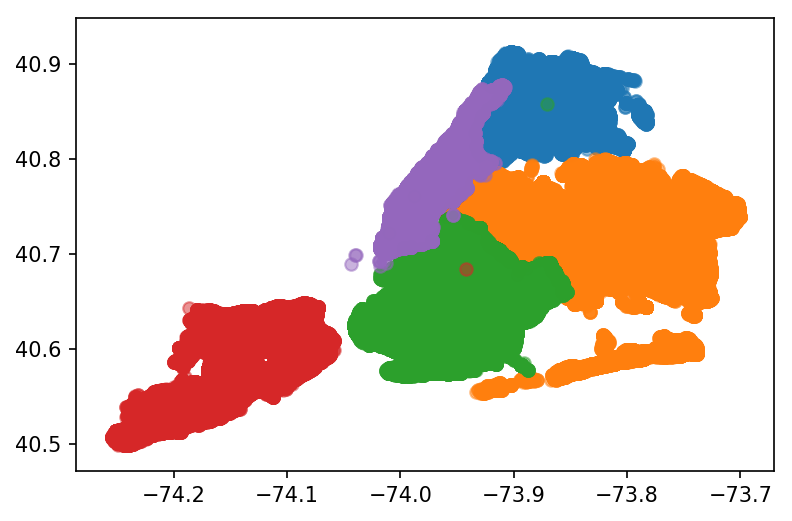

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
cols = getColors(myData_pd.where(myData_pd.District == 'BRONX').dropna())
scatter1 = plt.scatter(myData_pd.where(myData_pd.District == 'BRONX').dropna().Longitude, myData_pd.where(myData_pd.District == 'BRONX').dropna().Latitude, alpha=0.5, cmap=plt.cm.get_cmap('Blues'))
cols = getColors(myData_pd.where(myData_pd.District == 'QUEENS').dropna())
scatter2 = plt.scatter(myData_pd.where(myData_pd.District == 'QUEENS').dropna().Longitude, myData_pd.where(myData_pd.District == 'QUEENS').dropna().Latitude, alpha=0.5, cmap=plt.cm.get_cmap('Reds'))
cols = getColors(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna())
scatter3 = plt.scatter(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Longitude, myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Latitude, alpha=0.5, cmap=plt.cm.get_cmap('GnBu'))
cols = getColors(myData_pd.where(myData_pd.District == 'STATEN').dropna())
scatter4 = plt.scatter(myData_pd.where(myData_pd.District == 'STATEN').dropna().Longitude, myData_pd.where(myData_pd.District == 'STATEN').dropna().Latitude, alpha=0.5, cmap=plt.cm.get_cmap('RdPu'))
cols = getColors(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna())
scatter5 = plt.scatter(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Longitude, myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Latitude, alpha=0.5, cmap=plt.cm.get_cmap('Purples'))
fig.dpi = 150
plt.show();

## Всего обращений

In [20]:
toPrint = myData_pd.groupby(['District']).count()

In [ ]:
toPrint

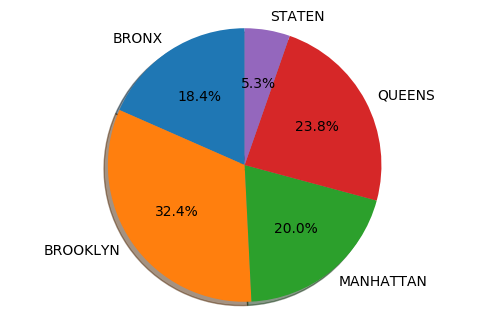

In [21]:
labels = toPrint.index.values
sizes = [x/sum(toPrint.City) for x in toPrint.City]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.dpi = 100
plt.show()

### Средняя задержка на выполнение обращения

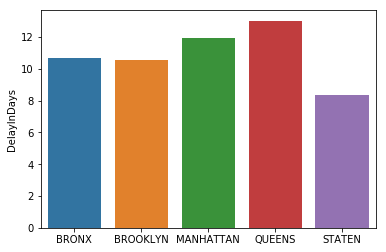

In [22]:
toPrint = myData_pd.groupby(['CreatedDate'])
sns.barplot(y="DelayInDays", x=toPrint.index.values[0:5], data=toPrint);

In [ ]:
toPrint = myData_pd.groupby(['CreatedDate']).mean()
toPrint = toPrint.where(toPrint.DelayInDays>0)
plt.plot(toPrint.index, toPrint.DelayInDays)
plt.show();

## NYPD

In [23]:
toPrint = myData_pd.groupby(['District','Agency'])
Bronx = toPrint.get_group(('BRONX','NYPD'))
Brooklyn = toPrint.get_group(('BROOKLYN','NYPD'))
Manhattan = toPrint.get_group(('MANHATTAN','NYPD'))
State = toPrint.get_group(('STATEN','NYPD'))
Queens = toPrint.get_group(('QUEENS','NYPD'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

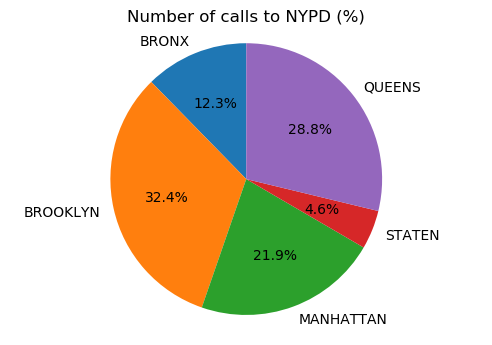

In [24]:
labels = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN', 'QUEENS']
sizes = []
for region in regions:
    sizes.append(len(region))
for size in sizes:
    size = size/sum(sizes)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
fig1.dpi = 100
plt.title('Number of calls to NYPD (%)')
plt.show()

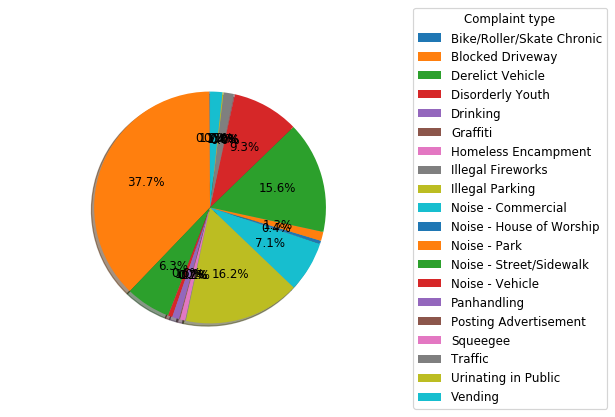

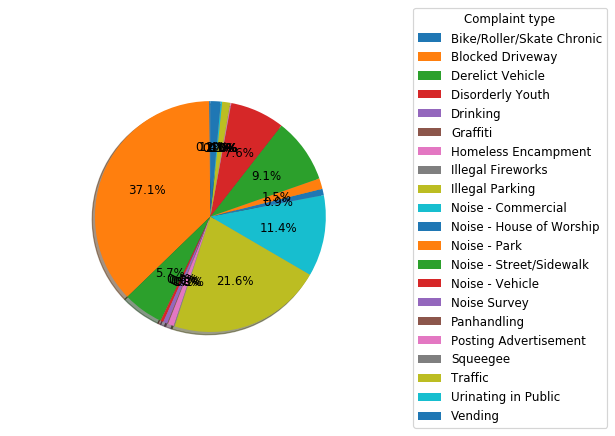

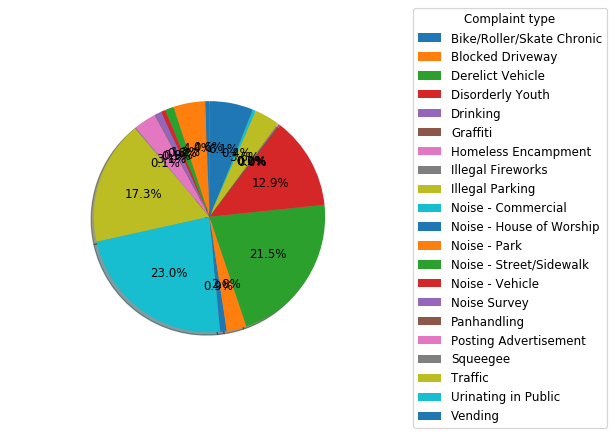

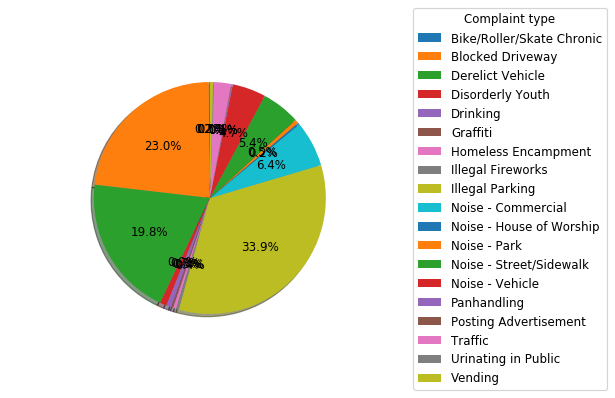

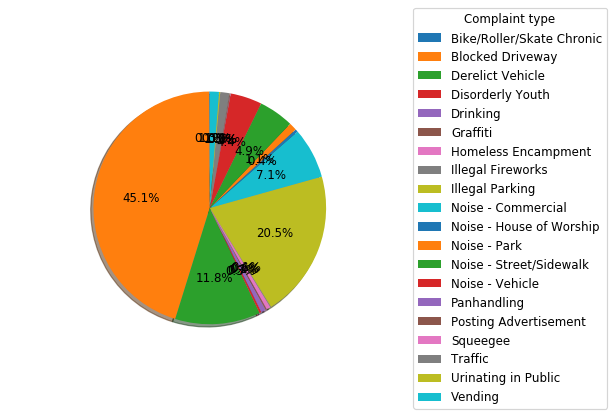

In [25]:
for region in regions:
    toPrint = region.groupby('Complaint Type').count()
    labels = toPrint.index.values
    sizes = [x/sum(toPrint.District) for x in toPrint.District]

    fig1, ax1 = plt.subplots()
    types, texts, autotexts = ax1.pie(sizes, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1.legend(types,
               labels,
               title="Complaint type",
               loc="center left",
               bbox_to_anchor=(1, 0, 0.5, 1))
    fig1.dpi = 85
    plt.show();

### Safety

In [49]:
toPrint = myData_pd.groupby(['District','Complaint Type'])
Bronx = toPrint.get_group(('BRONX','Safety'))
Brooklyn = toPrint.get_group(('BROOKLYN','Safety'))
Manhattan = toPrint.get_group(('MANHATTAN','Safety'))
State = toPrint.get_group(('STATEN','Safety'))
Queens = toPrint.get_group(('QUEENS','Safety'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

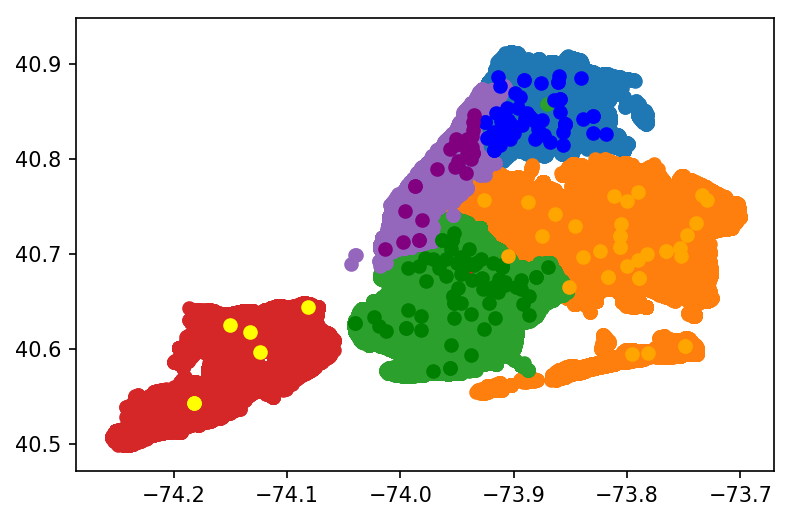

In [35]:
fig = plt.figure()
cols = getColors(myData_pd.where(myData_pd.District == 'BRONX').dropna())
scatter1 = plt.scatter(myData_pd.where(myData_pd.District == 'BRONX').dropna().Longitude, myData_pd.where(myData_pd.District == 'BRONX').dropna().Latitude,  cmap='Blues')
cols = getColors(myData_pd.where(myData_pd.District == 'QUEENS').dropna())
scatter2 = plt.scatter(myData_pd.where(myData_pd.District == 'QUEENS').dropna().Longitude, myData_pd.where(myData_pd.District == 'QUEENS').dropna().Latitude, cmap='Reds')
cols = getColors(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna())
scatter3 = plt.scatter(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Longitude, myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Latitude,  cmap='GnBu')
cols = getColors(myData_pd.where(myData_pd.District == 'STATEN').dropna())
scatter4 = plt.scatter(myData_pd.where(myData_pd.District == 'STATEN').dropna().Longitude, myData_pd.where(myData_pd.District == 'STATEN').dropna().Latitude, cmap='RdPu')
cols = getColors(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna())
scatter5 = plt.scatter(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Longitude, myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Latitude, cmap='Purples')
scatter6 = plt.scatter(Bronx.Longitude, Bronx.Latitude, c='blue')
scatter7 = plt.scatter(Brooklyn.Longitude, Brooklyn.Latitude, c='green')
scatter8 = plt.scatter(Manhattan.Longitude, Manhattan.Latitude, c='purple')
scatter9 = plt.scatter(State.Longitude, State.Latitude, c='yellow')
scatter10 = plt.scatter(Queens.Longitude, Queens.Latitude, c='orange')
fig.dpi = 150
plt.show();


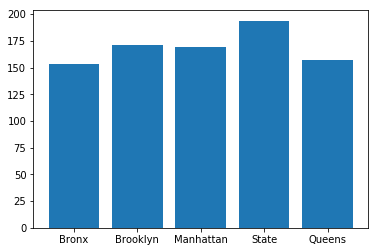

In [28]:
plt.bar(['Bronx', 'Brooklyn', 'Manhattan', 'State', 'Queens'], [region.DelayInDays.mean() for region in regions])
plt.show()

#### Rodent

In [50]:
toPrint = myData_pd.groupby(['District','Complaint Type'])
Bronx = toPrint.get_group(('BRONX','Homeless Encampment'))
Brooklyn = toPrint.get_group(('BROOKLYN','Homeless Encampment'))
Manhattan = toPrint.get_group(('MANHATTAN','Homeless Encampment'))
State = toPrint.get_group(('STATEN','Homeless Encampment'))
Queens = toPrint.get_group(('QUEENS','Homeless Encampment'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

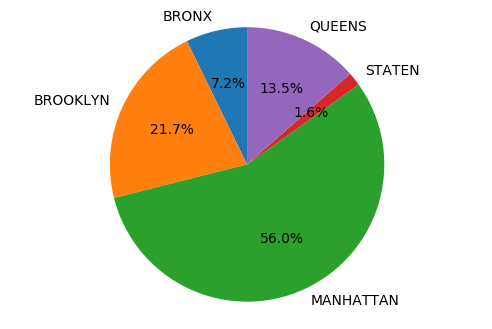

In [54]:
labels = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN', 'QUEENS']
sizes = []
for region in regions:
    sizes.append(len(region))
for size in sizes:
    size = size/sum(sizes)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
fig1.dpi = 100
plt.show()

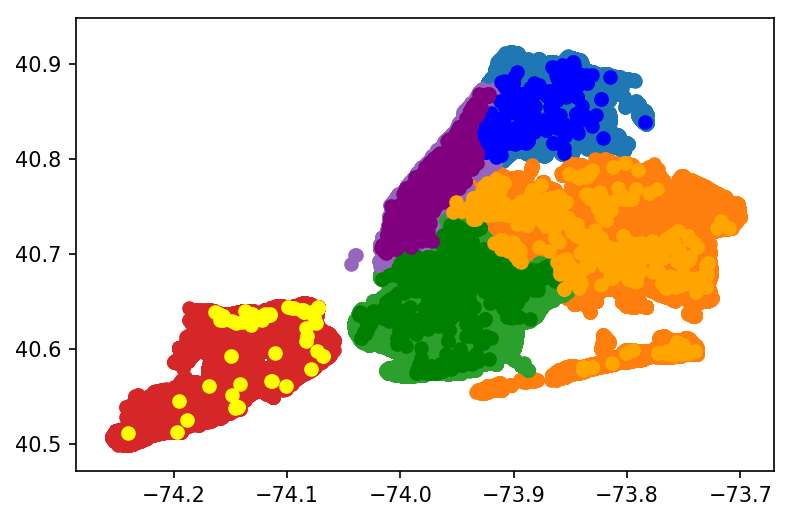

In [51]:
fig = plt.figure()
cols = getColors(myData_pd.where(myData_pd.District == 'BRONX').dropna())
scatter1 = plt.scatter(myData_pd.where(myData_pd.District == 'BRONX').dropna().Longitude, myData_pd.where(myData_pd.District == 'BRONX').dropna().Latitude,  cmap='Blues')
cols = getColors(myData_pd.where(myData_pd.District == 'QUEENS').dropna())
scatter2 = plt.scatter(myData_pd.where(myData_pd.District == 'QUEENS').dropna().Longitude, myData_pd.where(myData_pd.District == 'QUEENS').dropna().Latitude, cmap='Reds')
cols = getColors(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna())
scatter3 = plt.scatter(myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Longitude, myData_pd.where(myData_pd.District == 'BROOKLYN').dropna().Latitude,  cmap='GnBu')
cols = getColors(myData_pd.where(myData_pd.District == 'STATEN').dropna())
scatter4 = plt.scatter(myData_pd.where(myData_pd.District == 'STATEN').dropna().Longitude, myData_pd.where(myData_pd.District == 'STATEN').dropna().Latitude, cmap='RdPu')
cols = getColors(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna())
scatter5 = plt.scatter(myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Longitude, myData_pd.where(myData_pd.District == 'MANHATTAN').dropna().Latitude, cmap='Purples')
scatter6 = plt.scatter(Bronx.Longitude, Bronx.Latitude, c='blue')
scatter7 = plt.scatter(Brooklyn.Longitude, Brooklyn.Latitude, c='green')
scatter8 = plt.scatter(Manhattan.Longitude, Manhattan.Latitude, c='purple')
scatter9 = plt.scatter(State.Longitude, State.Latitude, c='yellow')
scatter10 = plt.scatter(Queens.Longitude, Queens.Latitude, c='orange')
fig.dpi = 150
plt.show();


#### DHPD 

In [57]:
toPrint = myData_pd.groupby(['District','Agency'])
Bronx = toPrint.get_group(('BRONX','HPD'))
Brooklyn = toPrint.get_group(('BROOKLYN','HPD'))
Manhattan = toPrint.get_group(('MANHATTAN','HPD'))
State = toPrint.get_group(('STATEN','HPD'))
Queens = toPrint.get_group(('QUEENS','HPD'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

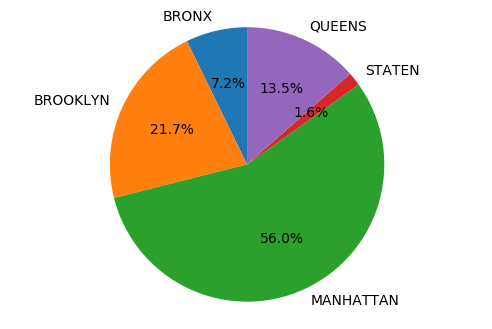

In [54]:
labels = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN', 'QUEENS']
sizes = []
for region in regions:
    sizes.append(len(region))
for size in sizes:
    size = size/sum(sizes)
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
fig1.dpi = 100
plt.show()

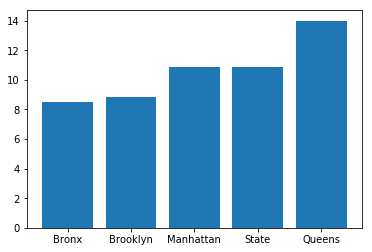

In [60]:
toPrint = myData_pd.groupby(['District','Agency'])
Bronx = toPrint.get_group(('BRONX','HPD'))
Brooklyn = toPrint.get_group(('BROOKLYN','HPD'))
Manhattan = toPrint.get_group(('MANHATTAN','HPD'))
State = toPrint.get_group(('STATEN','HPD'))
Queens = toPrint.get_group(('QUEENS','HPD'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

plt.bar(['Bronx', 'Brooklyn', 'Manhattan', 'State', 'Queens'], [region.DelayInDays.mean() for region in regions])
plt.show()

# labels = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN', 'QUEENS']
# sizes = []
# for region in regions:
#     sizes.append(len(region))
# for size in sizes:
#     size = size/sum(sizes)
    
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
#         startangle=90)
# ax1.axis('equal')
# fig1.dpi = 100
# plt.show()

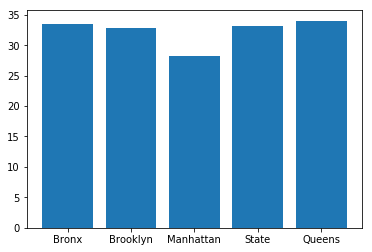

In [73]:
toPrint = myData_pd.groupby(['District','Agency'])
Bronx = toPrint.get_group(('BRONX','TLC'))
Brooklyn = toPrint.get_group(('BROOKLYN','TLC'))
Manhattan = toPrint.get_group(('MANHATTAN','TLC'))
State = toPrint.get_group(('STATEN','TLC'))
Queens = toPrint.get_group(('QUEENS','TLC'))
regions = [Bronx, Brooklyn, Manhattan, State, Queens]

plt.bar(['Bronx', 'Brooklyn', 'Manhattan', 'State', 'Queens'], [region.DelayInDays.mean() for region in regions])
plt.show()

# labels = ['BRONX', 'BROOKLYN', 'MANHATTAN', 'STATEN', 'QUEENS']
# sizes = []
# for region in regions:
#     sizes.append(len(region))
# for size in sizes:
#     size = size/sum(sizes)
    
# fig1, ax1 = plt.subplots()
# ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
#         startangle=90)
# ax1.axis('equal')
# fig1.dpi = 100
# plt.show()

### PAINT/PLASTER PROBLEM

In [ ]:
toPrint = myData.filter(myData['Complaint Type']=='PAINT/PLASTER').groupBy('District').count().orderBy('count', ascending=False).toPandas()
sns.barplot(y="count", x="District", data=toPrint.sort_values(by='count', ascending=False));

### Traffic Signal Condition PROBLEM

In [ ]:
toPrint = myData.filter(myData['Complaint Type']=='Traffic Signal Condition').groupBy('District').count().orderBy('count', ascending=False).toPandas()
sns.barplot(y="count", x="District", data=toPrint.sort_values(by='count', ascending=False));